In [68]:
import numpy as np
from numpy.linalg import solve, inv
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from Code.fixed_income_derivatives_E2024 import *

In [55]:
#1.b)
T = [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2]
n = 8
C = np.zeros([n,len(T)])
C[0,:] = [-101.3, 2.55, 0, 102.55, 0, 0, 0, 0]
C[1,:] = [0, 102.45, 0, -4.4, 0, 0, 0, -104.4]
C[2,:] = [-101.3, 0, 0, 4.9, 0, 0, 0, 104.9]
C[3,:] = [7/4, 7/4, 7/4, 100 + 7/4, 0, 0, 0, 0]
C[4,:] = [0, 5/2, 0, 5/2, 0, 100 + 5/2, 0, 0]
C[5,:] = [0, 0, 0, 6, 0, 0, 0, 100 + 6]
C[6,:] = [4.5/4, 4.5/4, 4.5/4, 4.5/4, 4.5/4, 100 + 4.5/4, 0, 0]
C[7,:] = [5.5/4, 5.5/4, 5.5/4, 5.5/4, 5.5/4, 5.5/4, 5.5/4, 100 + 5.5/4]
pi = np.array([0.79492002, -1.02540877,  2.05066409, 103.02163487, 101.80152680, 104.48120266, 101.10990798, 103.67216735])

In [56]:
#1.c)
T = np.array([5, 11, 17, 23, 29, 35, 41, 47])/24
ZCB = solve(C, pi)
print(ZCB)

[0.99060312 0.9802517  0.97073639 0.96190516 0.95363276 0.94581595
 0.93836974 0.93122426]


[0.04531828 0.04351833 0.04192989 0.04052809 0.03929101 0.03819928
 0.03723584 0.03638561]
[0.         0.04223985 0.03920865 0.03672388 0.0346985  0.03305848
 0.03174103 0.03069284]


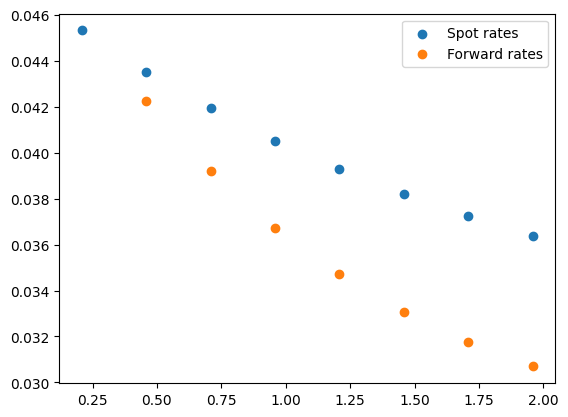

In [57]:
#1.d)
R = spot_rates_from_zcb_prices(T, ZCB)
forward_rates = forward_libor_rates_from_zcb_prices(T, ZCB)
print(R)
print(forward_rates)
plt.scatter(T, R, label='Spot rates')
plt.scatter(T[1:], forward_rates[1:], label='Forward rates')
plt.legend()
plt.show()

In [58]:
#1.e)
R_new = R - 0.001
ZCB_new = zcb_prices_from_spot_rates(T, R_new)
pi_new = C @ ZCB_new
print(pi_new)

[  0.86973647  -1.1740026    2.22576323 103.11782696 101.94643885
 104.68023231 101.25333922 103.86602576]


In [59]:
#1.f)
PV_fixed = 50*0.051*ZCB[1]+50*0.051*ZCB[3]
PV_float = 25*0.052*ZCB[0] + 100*(ZCB[0]-ZCB[3])
print(PV_fixed - PV_float)
par_swap_rate = PV_float/(100*165/360*ZCB[1]+50*ZCB[3])
print(par_swap_rate)

0.7949200199999966
0.04469388618153486


In [60]:
#1.g)
accrual_factor = 165/360*ZCB[1]+1/2*ZCB[3]
print(accrual_factor)
PnL = accrual_factor*(0.051-par_swap_rate)
print(PnL)

0.930234610936274
0.005866165334439779


In [61]:
#1.h)
#Yes, the PnL is positive, which means that the fixed rate receiver has made a profit. This is because the fixed rate receiver has received a fixed rate that is higher than the par swap rate, which means that the fixed rate receiver has received more money than he has paid out.

In [71]:
#1.i)
C_bond = np.array([0, 2.6, 0, 2.6, 0, 2.6, 0, 102.6])
bond_price = np.sum(C_bond * ZCB)
print(bond_price)

103.0523385081963


In [70]:
#1.j)
replicating_portfolio = C_bond @ inv(C)
print(replicating_portfolio)

[-0.0319491   0.02555447  0.0319491   0.          0.02536585  0.96147572
  0.          0.        ]


In [ ]:
#1.k)
